In [2]:
!git clone https://github.com/PinaColadast/eth-capstone-treewater-deficit.git
!cd eth-capstone-treewater-deficit/ && git pull origin transformer_colab &&  git checkout transformer_colab
!ls

fatal: destination path 'eth-capstone-treewater-deficit' already exists and is not an empty directory.
From https://github.com/PinaColadast/eth-capstone-treewater-deficit
 * branch            transformer_colab -> FETCH_HEAD
Already up to date.
M	src/treewater/__pycache__/__init__.cpython-312.pyc
M	src/treewater/__pycache__/utils.cpython-312.pyc
Already on 'transformer_colab'
Your branch is up to date with 'origin/transformer_colab'.
eth-capstone-treewater-deficit	sample_data


In [3]:
import sys
sys.path.append('/content/eth-capstone-treewater-deficit/src')
# sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import collections

from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

In [4]:
import importlib
import treewater.utils as utils
importlib.reload(utils)

# check presence
print(hasattr(utils, "build_autoregressive_training_data_fast_LSTM_scheduled"))
print(hasattr(utils, "teacher_forcing_prob"))
print(hasattr(utils, "cross_validation_LSTM_FT"))
print(hasattr(utils, "teacher_forcing_prob_stepwise"))
print(hasattr(utils, "cross_validation_LSTM_AR"))
print(hasattr(utils, "clip_and_inverse_log2_transform"))

True
True
True
True
True
True


In [5]:
# set global random seed
seed = 66666
tf.random.set_seed(
    seed
)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # suppress INFO + WARNING
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [6]:
with tf.device("/GPU:0"):
    y = tf.sign(tf.random.uniform([1024,1024], minval=-1, maxval=1))


In [7]:
# derived_path = "/home/renku/work/eth-capstone-treewater-deficit/data"
# data_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/tstoy04"

derived_path = "/content/eth-capstone-treewater-deficit/data"
data_dir = "/content/eth-capstone-treewater-deficit/data/tstoy04"

In [8]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [9]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [10]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [11]:
# twd_tree_series_sites

In [12]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [13]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [14]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

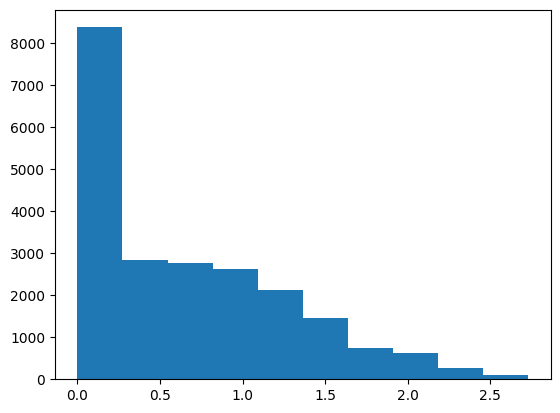

In [15]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [16]:
# Configure features
config = FeatureConfig()
lag_n =7 # use 7 and smaller model size 

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)





### build Transformer - using encoder to train the model


In [17]:

batch_size = 128
lag_n = 7

In [18]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    

In [19]:
# dynamic input
def build_autoregressive_model_lstm( train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 16):
     # we don't actually need the input features but rather the shape information
    timesteps = lag_n
    n_features = train_X_ts_at.shape[2] # include TWD + other variables

    dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")
    x_dyn = tf_keras.layers.LSTM(hidden_unit, return_sequences=False)(dyn_in)
    x_dyn = tf_keras.layers.Dense(hidden_unit, activation="relu")(x_dyn)

    # current day other features
    n_static = train_day_feat_X.shape[1]
    static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
    x_static = tf_keras.layers.Dense(4, 
                                     activation="relu",
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                     )(static_in)

    # static input
    n_current = train_static_X_ts.shape[1]
    curr_in = tf_keras.Input(shape=(n_current,), name="static")
    x_curr = tf_keras.layers.Dense(4, 
                                   activation="relu",
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                   )(curr_in)


    combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
    x = tf_keras.layers.Dense(16, activation="relu")(combined)
    out = tf_keras.layers.Dense(1, activation = "linear")(x)


    model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
    )

    model_at.compile(
        optimizer=tf_keras.optimizers.Adam(learning_rate=1e-3/2),
        # optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
        loss="mae",
        metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
        
    ],
    jit_compile=False
    )
    return model_at

In [20]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    



In [21]:
# Disable XLA/JIT (this is what’s crashing)
tf.config.optimizer.set_jit(False)

# Optional but recommended for GPU stability in notebooks
gpus = tf.config.list_physical_devices("GPU")
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs:", gpus)


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
import tensorflow as tf

x = tf.random.uniform([1024, 1024], minval=-1, maxval=1)
with tf.device("/GPU:0"):
    y = tf.sign(x)           # should run fine without XLA
print(y.device)


/job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
# create two models with different hidden units 

# with tf.device("/CPU:0"):

model_fold1 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 16)
maes_cv_at, rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = cross_validation_LSTM(
    model_fold1,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)

# with tf.device("/CPU:0"):
model_fold2 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at , lag_n, hidden_unit = 32)
maes_cv_at2, rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2  = cross_validation_LSTM(
    model_fold2,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)


Training fold 1/4
Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.7433 - mae: 0.7315 - rmse: 0.9315 - val_loss: 0.4916 - val_mae: 0.4800 - val_rmse: 0.6806
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5816 - mae: 0.5700 - rmse: 0.7534 - val_loss: 0.4546 - val_mae: 0.4431 - val_rmse: 0.6175
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4804 - mae: 0.4689 - rmse: 0.6218 - val_loss: 0.4306 - val_mae: 0.4192 - val_rmse: 0.5792
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4179 - mae: 0.4066 - rmse: 0.5272 - val_loss: 0.4147 - val_mae: 0.4034 - val_rmse: 0.5576
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3722 - mae: 0.3610 - rmse: 0.4610 - val_loss: 0.4106 - val_mae: 0.3994 - val_rmse: 0.5524
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3329 - mae: 0.3218 - rmse: 0.4119 - val_loss: 0.4192 - val_mae: 0.4081 - val_rmse: 0.5629
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2985 - mae: 0.2875 - 

In [ ]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"  # disable auto-jit
os.environ["XLA_FLAGS"] = ""                        # clear any xla flags (optional)

import tensorflow as tf
tf.config.optimizer.set_jit(False)                  # disable XLA JIT globally



In [ ]:
rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2
rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at

([0.9126954855582201,
  0.44106515177027167,
  0.4404012177687316,
  0.6521516383506042],
 [0.37974050641059875,
  0.2209673970937729,
  0.15933972597122192,
  0.20982638001441956],
 [0.5304750800132751,
  0.871733546257019,
  0.9195662140846252,
  0.8893380761146545],
 [-1.699412899935401,
  0.49837177964239876,
  0.33085334602542793,
  -0.07714391941758914])

In [21]:
print(rmses_cv_at)
rmses_cv_at2

NameError: name 'rmses_cv_at' is not defined

[Text(1, 0, 'hidden size =16'), Text(2, 0, 'hidden size =32')]

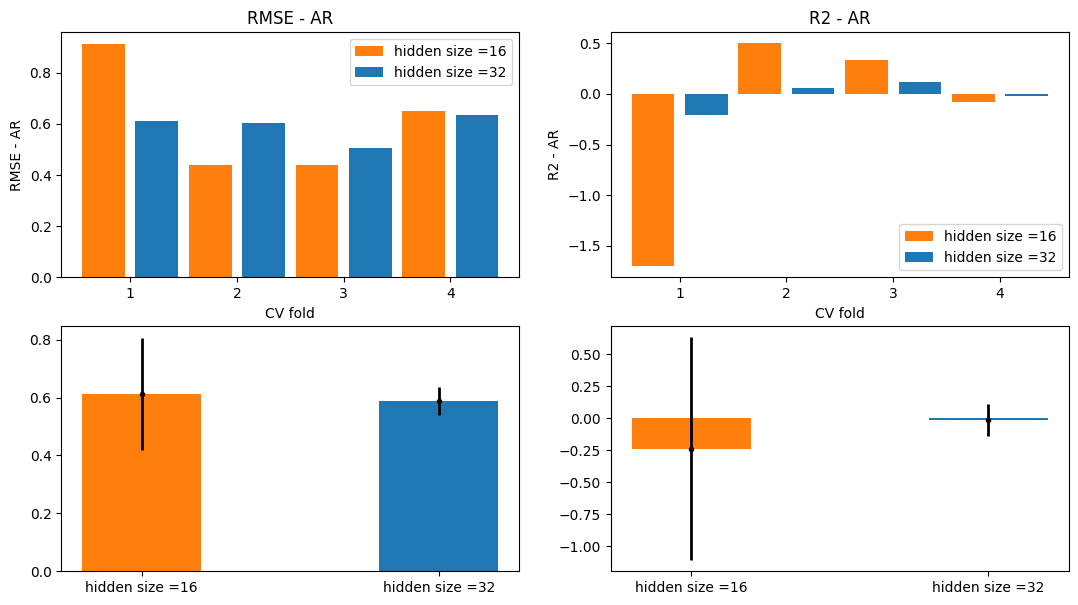

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 7))

ax1.bar(np.arange(0.75,4.75, 1), rmses_cv_at, color='tab:orange', width = 0.4)
ax1.bar(np.arange(1.25,5.25,1),rmses_cv_at2, color = "tab:blue", width = 0.4)

ax1.set_xticks(range(1,5))
ax1.legend(['hidden size =16', 'hidden size =32'])
ax1.set_ylabel('RMSE - AR')
ax1.set_xlabel("CV fold")
ax1.set_title("RMSE - AR")
# rmses_cv_at


ax2.bar(np.arange(0.75, 4.75, 1), r2s_cv_at, color='tab:orange', width = 0.4)
ax2.bar(np.arange(1.25,5.25,1),r2s_cv_at2, color = "tab:blue", width = 0.4)
ax2.set_xticks(range(1,5))
ax2.legend(['hidden size =16', 'hidden size =32'])
ax2.set_ylabel('R2 - AR')
ax2.set_xlabel("CV fold")
ax2.set_title("R2 - AR")   


ax3.bar([1,2],  [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax3.errorbar(x = [1,2], y = [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)], 
             yerr=[np.std(rmses_cv_at), np.std(rmses_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['hidden size =16', 'hidden size =32'])


ax4.bar([1,2],  [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax4.errorbar(x = [1,2], y = [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)], 
             yerr=[np.std(r2s_cv_at), np.std(r2s_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax4.set_xticks([1,2])
ax4.set_xticklabels(['hidden size =16', 'hidden size =32'])
             

- performance appears more stable when hidden space dimension is 32 

In [47]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 16)
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2192 - mae: 0.3096 - rmse: 0.4555 - val_loss: 0.0651 - val_mae: 0.1673 - val_rmse: 0.2331
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0635 - mae: 0.1598 - rmse: 0.2314 - val_loss: 0.0465 - val_mae: 0.1366 - val_rmse: 0.1931
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0509 - mae: 0.1384 - rmse: 0.2055 - val_loss: 0.0429 - val_mae: 0.1305 - val_rmse: 0.1866
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0450 - mae: 0.1280 - rmse: 0.1935 - val_loss: 0.0365 - val_mae: 0.1179 - val_rmse: 0.1716
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0407 - mae: 0.1206 - rmse: 0.1848 - val_loss: 0.0338 - val_mae: 0.1135 - val_rmse: 0.1664
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0378 - mae: 0.1158 - rmse: 0.1792 - val_loss: 0.0325 - val_mae: 0.1146 - val_rmse: 0.1653
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0356 - mae: 0.1131 - rmse:

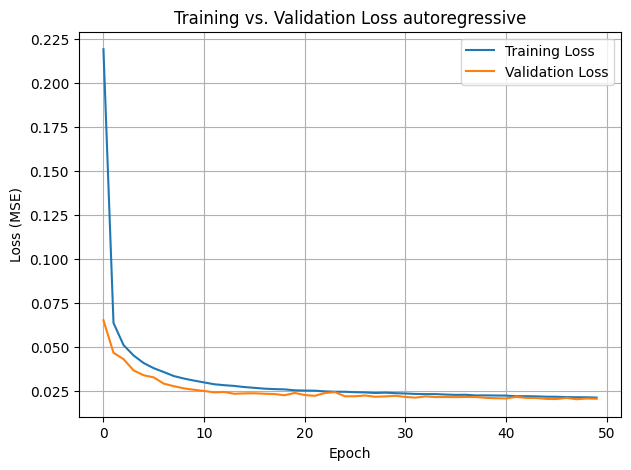

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
rmse: 0.176055, r2: 0.949403 


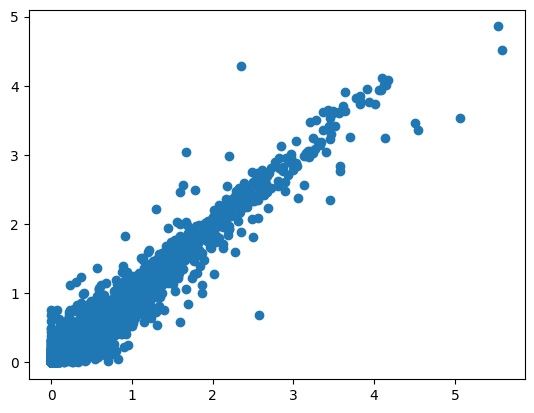

In [57]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_pred_val_1day_at), clip_and_inverse_log2_transform(val_y_at))
r2_1day_at = r2_score(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))

In [86]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [87]:
r2_at = r2_score(clip_and_inverse_log2_transform(y_val_at), clip_and_inverse_log2_transform(y_pred_val_at))
rmse_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at), clip_and_inverse_log2_transform(y_pred_val_at))

print(f"r2: {r2_at}\n rmse: {rmse_at}")

r2: 0.69364641513352
 rmse: 0.43770478658342693


add cross-validation

In [63]:
# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# fine tune the model within CV

maes_cv_at_finetune, rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = cross_validation_LSTM_FT(
    model_ar,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=50,
    batch_size = batch_size
)



Training fold 1/4
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0956 - mae: 0.2230 - rmse: 0.3086 - val_loss: 0.0539 - val_mae: 0.1645 - val_rmse: 0.2313
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0871 - mae: 0.2148 - rmse: 0.2946 - val_loss: 0.0489 - val_mae: 0.1559 - val_rmse: 0.2202
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0840 - mae: 0.2110 - rmse: 0.2892 - val_loss: 0.0474 - val_mae: 0.1549 - val_rmse: 0.2170
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0817 - mae: 0.2082 - rmse: 0.2853 - val_loss: 0.0485 - val_mae: 0.1572 - val_rmse: 0.2194
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0797 - mae: 0.2062 - rmse: 0.2818 - val_loss: 0.0480 - val_mae: 0.1563 - val_rmse: 0.2184
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0780 - mae: 0.2044 - rmse: 0.2786 - val_loss: 0.0480 - val_mae: 0.1561 - val_rmse: 0.2183
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0764 - mae: 0.2027 - 

2025-12-29 18:35:54.434939: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [69]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = build_autoregressive_training_data_fast_LSTM(
    model=model_at,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
)

ds_ar = tf.data.Dataset.from_tensor_slices(
    ((X_dyn_ar, X_day_ar, X_static_ar), y_ar)
).batch(64).prefetch(tf.data.AUTOTUNE)

In [70]:
# train final model on the full training set with AR-corrupted data
E2 = 50

# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# now fine-tune on AR-corrupted dataset
model_ar.fit(
    ds_ar,
    epochs=E2,
    validation_data=val_ds_at
)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0880 - mae: 0.2148 - rmse: 0.2960 - val_loss: 0.0296 - val_mae: 0.1248 - val_rmse: 0.1711
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0877 - mae: 0.2148 - rmse: 0.2955 - val_loss: 0.0318 - val_mae: 0.1310 - val_rmse: 0.1773
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0868 - mae: 0.2128 - rmse: 0.2939 - val_loss: 0.0327 - val_mae: 0.1331 - val_rmse: 0.1797
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0861 - mae: 0.2115 - rmse: 0.2927 - val_loss: 0.0343 - val_mae: 0.1375 - val_rmse: 0.1841
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0856 - mae: 0.2106 - rmse: 0.2917 - val_loss: 0.0348 - val_mae: 0.1392 - val_rmse: 0.1855
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0851 - mae: 0.2099 - rmse: 0.2909 - val_loss: 0.0360 - val_mae: 0.1422 - val_rmse: 0.1886
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0847 - mae: 0.2094 - rmse:

In [71]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = compute_recursive_predictions_fast_LSTM(model_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [72]:
r2_FT = r2_score(clip_and_inverse_log2_transform(y_val_at_FT), clip_and_inverse_log2_transform(y_pred_val_at_FT))
rmse_FT = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at_FT), clip_and_inverse_log2_transform(y_pred_val_at_FT))

print(f"r2: {r2_FT}\n rmse: {rmse_FT}")

r2: 0.027230332635112098
 rmse: 0.7799644754899039


### scheduled sampling - train model

cross validation - implement cross validation

In [ ]:
num_epochs = 45

# init model with same architecture
model_at_ar_cv = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.set_weights(model_at.get_weights())

maes_cv_at_ar, rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = cross_validation_LSTM_AR(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=num_epochs,
    batch_size = batch_size,
    p_min = 0.1,
    warmup_epochs=3,
    frac_decay=0.9,
    slow_decay=True)




Training fold 1/4
Epoch 1/45 - loss: 0.0215 - rmse: 0.1454 - val_loss: 0.0587 - val_rmse: 0.2425 - p_tf: 1.000
Epoch 2/45 - loss: 0.0196 - rmse: 0.1383 - val_loss: 0.0451 - val_rmse: 0.2123 - p_tf: 1.000
Epoch 3/45 - loss: 0.0193 - rmse: 0.1377 - val_loss: 0.0521 - val_rmse: 0.2285 - p_tf: 1.000
Epoch 4/45 - loss: 0.0202 - rmse: 0.1411 - val_loss: 0.0413 - val_rmse: 0.2031 - p_tf: 0.871
Epoch 5/45 - loss: 0.0201 - rmse: 0.1404 - val_loss: 0.0466 - val_rmse: 0.2158 - p_tf: 0.871
Epoch 6/45 - loss: 0.0197 - rmse: 0.1389 - val_loss: 0.0449 - val_rmse: 0.2119 - p_tf: 0.871
Epoch 7/45 - loss: 0.0197 - rmse: 0.1388 - val_loss: 0.0410 - val_rmse: 0.2025 - p_tf: 0.871
Epoch 8/45 - loss: 0.0193 - rmse: 0.1375 - val_loss: 0.0386 - val_rmse: 0.1964 - p_tf: 0.871
Epoch 9/45 - loss: 0.0209 - rmse: 0.1430 - val_loss: 0.0425 - val_rmse: 0.2060 - p_tf: 0.743
Epoch 10/45 - loss: 0.0205 - rmse: 0.1416 - val_loss: 0.0374 - val_rmse: 0.1931 - p_tf: 0.743
Epoch 11/45 - loss: 0.0199 - rmse: 0.1396 - val_los

2025-12-29 20:01:16.963952: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/45 - loss: 0.0229 - rmse: 0.1503 - val_loss: 0.0448 - val_rmse: 0.2116 - p_tf: 0.614
Epoch 17/45 - loss: 0.0217 - rmse: 0.1462 - val_loss: 0.0619 - val_rmse: 0.2490 - p_tf: 0.614
Epoch 18/45 - loss: 0.0227 - rmse: 0.1490 - val_loss: 0.0548 - val_rmse: 0.2344 - p_tf: 0.614
Epoch 19/45 - loss: 0.0246 - rmse: 0.1558 - val_loss: 0.0548 - val_rmse: 0.2343 - p_tf: 0.486
Epoch 20/45 - loss: 0.0291 - rmse: 0.1691 - val_loss: 0.0669 - val_rmse: 0.2591 - p_tf: 0.486
Epoch 21/45 - loss: 0.0284 - rmse: 0.1675 - val_loss: 0.0489 - val_rmse: 0.2213 - p_tf: 0.486
Epoch 22/45 - loss: 0.0256 - rmse: 0.1589 - val_loss: 0.0617 - val_rmse: 0.2486 - p_tf: 0.486
Epoch 23/45 - loss: 0.0257 - rmse: 0.1593 - val_loss: 0.0572 - val_rmse: 0.2395 - p_tf: 0.486
Epoch 24/45 - loss: 0.0288 - rmse: 0.1686 - val_loss: 0.0605 - val_rmse: 0.2463 - p_tf: 0.357
Epoch 25/45 - loss: 0.0299 - rmse: 0.1720 - val_loss: 0.0675 - val_rmse: 0.2603 - p_tf: 0.357
Epoch 26/45 - loss: 0.0331 - rmse: 0.1809 - val_loss: 0.0741

2025-12-29 20:10:04.485376: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/45 - loss: 0.0235 - rmse: 0.1509 - val_loss: 0.0563 - val_rmse: 0.2361 - p_tf: 1.000
Epoch 4/45 - loss: 0.0244 - rmse: 0.1538 - val_loss: 0.0517 - val_rmse: 0.2261 - p_tf: 0.871
Epoch 5/45 - loss: 0.0234 - rmse: 0.1507 - val_loss: 0.0507 - val_rmse: 0.2240 - p_tf: 0.871
Epoch 6/45 - loss: 0.0226 - rmse: 0.1479 - val_loss: 0.0490 - val_rmse: 0.2202 - p_tf: 0.871
Epoch 7/45 - loss: 0.0220 - rmse: 0.1462 - val_loss: 0.0519 - val_rmse: 0.2267 - p_tf: 0.871
Epoch 8/45 - loss: 0.0214 - rmse: 0.1440 - val_loss: 0.0467 - val_rmse: 0.2149 - p_tf: 0.871
Epoch 9/45 - loss: 0.0238 - rmse: 0.1524 - val_loss: 0.0468 - val_rmse: 0.2153 - p_tf: 0.743
Epoch 10/45 - loss: 0.0235 - rmse: 0.1513 - val_loss: 0.0468 - val_rmse: 0.2153 - p_tf: 0.743
Epoch 11/45 - loss: 0.0236 - rmse: 0.1515 - val_loss: 0.0483 - val_rmse: 0.2187 - p_tf: 0.743
Epoch 12/45 - loss: 0.0231 - rmse: 0.1500 - val_loss: 0.0472 - val_rmse: 0.2162 - p_tf: 0.743
Epoch 13/45 - loss: 0.0231 - rmse: 0.1501 - val_loss: 0.0464 - val_

2025-12-29 20:33:30.621910: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21/45 - loss: 0.0324 - rmse: 0.1786 - val_loss: 0.0223 - val_rmse: 0.1482 - p_tf: 0.486
Epoch 22/45 - loss: 0.0314 - rmse: 0.1755 - val_loss: 0.0215 - val_rmse: 0.1454 - p_tf: 0.486
Epoch 23/45 - loss: 0.0312 - rmse: 0.1751 - val_loss: 0.0216 - val_rmse: 0.1457 - p_tf: 0.486
Epoch 24/45 - loss: 0.0358 - rmse: 0.1876 - val_loss: 0.0221 - val_rmse: 0.1475 - p_tf: 0.357
Epoch 25/45 - loss: 0.0364 - rmse: 0.1896 - val_loss: 0.0213 - val_rmse: 0.1447 - p_tf: 0.357
Epoch 26/45 - loss: 0.0356 - rmse: 0.1873 - val_loss: 0.0221 - val_rmse: 0.1474 - p_tf: 0.357
Epoch 27/45 - loss: 0.0372 - rmse: 0.1916 - val_loss: 0.0217 - val_rmse: 0.1460 - p_tf: 0.357
Epoch 28/45 - loss: 0.0361 - rmse: 0.1885 - val_loss: 0.0238 - val_rmse: 0.1533 - p_tf: 0.357
Epoch 29/45 - loss: 0.0484 - rmse: 0.2189 - val_loss: 0.0258 - val_rmse: 0.1595 - p_tf: 0.229
Epoch 30/45 - loss: 0.0550 - rmse: 0.2330 - val_loss: 0.0455 - val_rmse: 0.2129 - p_tf: 0.229
Epoch 31/45 - loss: 0.0655 - rmse: 0.2550 - val_loss: 0.0467

- more epochs, decay slower, stepwise training 
- hidden size 16, shorter window

In [78]:
# now do scheduled sampling training on the full training set
num_epochs = 120

history_ar_at = {
"loss": [],
"rmse": [],
"val_loss": [],
"val_rmse": [],
"p_tf": []
}


# init model with same architecture
model_at_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar.set_weights(model_at.get_weights())



for epoch in range(num_epochs):
        # train model with teacher forcing for the first epoch 
    p_tf = teacher_forcing_prob_stepwise(epoch, num_epochs,epoch_per_step=15, step_size=0.1, p0=1.0, p_min=0.1, warmup_epochs=3, frac_decay=0.9)
    history_ar_at["p_tf"].append(p_tf)

    # rebuild AR / scheduled-sampling training data
    X_dyn_ar_at, X_day_ar_at, X_static_ar_at, y_ar_at = build_autoregressive_training_data_fast_LSTM_scheduled(
        model_at_ar,
        train_df_at,
        feature_window_size=lag_n,
        label_window_size=1,
        shift=1,
        config=config,
        batch_size=batch_size,
        teacher_forcing_prob=p_tf,
    )

    train_ds_at_decay = (
        tf.data.Dataset.from_tensor_slices(((X_dyn_ar_at, X_day_ar_at, X_static_ar_at), y_ar_at))
        .shuffle(len(X_dyn_ar_at))
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # one epoch of manual training
    epoch_loss = tf.keras.metrics.Mean()
    epoch_rmse = tf.keras.metrics.RootMeanSquaredError()

    for (x_dyn, x_day, x_stat), y in train_ds_at_decay:
        with tf.GradientTape() as tape:
            preds = model_at_ar([x_dyn, x_day, x_stat], training=True)
            loss = model_at_ar.compute_loss(x=None, y=y, y_pred=preds, sample_weight=None, training=True)

        grads = tape.gradient(loss, model_at_ar.trainable_variables)
        model_at_ar.optimizer.apply_gradients(zip(grads, model_at_ar.trainable_variables))      
        epoch_loss.update_state(loss)
        epoch_rmse.update_state(y, preds)

    # validation
    val_loss_metric = tf.keras.metrics.Mean()
    val_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    for (x_dyn_v, x_day_v, x_stat_v), y_v in val_ds_at:
        preds_v = model_at_ar([x_dyn_v, x_day_v, x_stat_v], training=False)
        v_loss = model_at_ar.compute_loss(x=None, y=y_v, y_pred=preds_v, sample_weight=None, training=False)
        val_loss_metric.update_state(v_loss)
        val_rmse_metric.update_state(y_v, preds_v)

    history_ar_at["loss"].append(epoch_loss.result().numpy())
    history_ar_at["rmse"].append(epoch_rmse.result().numpy())
    history_ar_at["val_loss"].append(val_loss_metric.result().numpy())
    history_ar_at["val_rmse"].append(val_rmse_metric.result().numpy())
    history_ar_at["p_tf"].append(p_tf)

    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"loss: {history_ar_at['loss'][-1]:.4f} - rmse: {history_ar_at['rmse'][-1]:.4f} - "
        f"val_loss: {history_ar_at['val_loss'][-1]:.4f} - val_rmse: {history_ar_at['val_rmse'][-1]:.4f} - "
        f"p_tf: {p_tf:.3f}"
    )

Epoch 1/120 - loss: 0.0212 - rmse: 0.1443 - val_loss: 0.0211 - val_rmse: 0.1440 - p_tf: 1.000
Epoch 2/120 - loss: 0.0210 - rmse: 0.1435 - val_loss: 0.0205 - val_rmse: 0.1419 - p_tf: 1.000
Epoch 3/120 - loss: 0.0212 - rmse: 0.1441 - val_loss: 0.0202 - val_rmse: 0.1408 - p_tf: 1.000
Epoch 4/120 - loss: 0.0232 - rmse: 0.1511 - val_loss: 0.0209 - val_rmse: 0.1432 - p_tf: 0.871
Epoch 5/120 - loss: 0.0235 - rmse: 0.1520 - val_loss: 0.0199 - val_rmse: 0.1397 - p_tf: 0.871
Epoch 6/120 - loss: 0.0231 - rmse: 0.1506 - val_loss: 0.0203 - val_rmse: 0.1411 - p_tf: 0.871
Epoch 7/120 - loss: 0.0231 - rmse: 0.1506 - val_loss: 0.0205 - val_rmse: 0.1419 - p_tf: 0.871
Epoch 8/120 - loss: 0.0232 - rmse: 0.1512 - val_loss: 0.0201 - val_rmse: 0.1403 - p_tf: 0.871
Epoch 9/120 - loss: 0.0230 - rmse: 0.1503 - val_loss: 0.0223 - val_rmse: 0.1481 - p_tf: 0.871
Epoch 10/120 - loss: 0.0229 - rmse: 0.1500 - val_loss: 0.0208 - val_rmse: 0.1429 - p_tf: 0.871
Epoch 11/120 - loss: 0.0229 - rmse: 0.1499 - val_loss: 0.02

2025-12-29 21:43:16.614330: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44/120 - loss: 0.0266 - rmse: 0.1618 - val_loss: 0.0211 - val_rmse: 0.1440 - p_tf: 0.614
Epoch 45/120 - loss: 0.0275 - rmse: 0.1645 - val_loss: 0.0207 - val_rmse: 0.1424 - p_tf: 0.614
Epoch 46/120 - loss: 0.0266 - rmse: 0.1620 - val_loss: 0.0216 - val_rmse: 0.1458 - p_tf: 0.614
Epoch 47/120 - loss: 0.0282 - rmse: 0.1667 - val_loss: 0.0209 - val_rmse: 0.1434 - p_tf: 0.614
Epoch 48/120 - loss: 0.0268 - rmse: 0.1623 - val_loss: 0.0213 - val_rmse: 0.1446 - p_tf: 0.614
Epoch 49/120 - loss: 0.0302 - rmse: 0.1727 - val_loss: 0.0212 - val_rmse: 0.1442 - p_tf: 0.486
Epoch 50/120 - loss: 0.0303 - rmse: 0.1729 - val_loss: 0.0232 - val_rmse: 0.1510 - p_tf: 0.486
Epoch 51/120 - loss: 0.0330 - rmse: 0.1805 - val_loss: 0.0219 - val_rmse: 0.1468 - p_tf: 0.486
Epoch 52/120 - loss: 0.0325 - rmse: 0.1790 - val_loss: 0.0215 - val_rmse: 0.1453 - p_tf: 0.486
Epoch 53/120 - loss: 0.0310 - rmse: 0.1748 - val_loss: 0.0209 - val_rmse: 0.1431 - p_tf: 0.486
Epoch 54/120 - loss: 0.0310 - rmse: 0.1747 - val_l

maybe adjust loss function?

In [79]:
# save training history
train_his_path = f"/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/derived/training_history/history_ar_at_LSTM_scheduled_sampling_log.npy"
np.save(train_his_path, history_ar_at)

In [80]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= compute_recursive_predictions_fast_LSTM(model_at_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(clip_and_inverse_log2_transform(y_val_at_ar),clip_and_inverse_log2_transform(y_pred_val_at_ar))
rmse_at_ar = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at_ar), clip_and_inverse_log2_transform(y_pred_val_at_ar))

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: 0.18266580596301996
 rmse: 0.7149400836851747


In [81]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (hidden=16)'] *4 + ['teacher_forcing (hidden=32)'] *4 + ['fine_tuned (hidden=16)'] *4 + ['scheduled_sampling (hidden=16)'] *4,    
    "cv_fold"  : [i for i in range(1, len(maes_cv_at_ar) + 1)] *4,
    "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["mae", "rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

In [82]:
df_model_p_long.loc[df_model_p_long.metric == "r2_recursive",]

,model,cv_fold,metric,value
64,teacher_forcing (hidden=16),1,r2_recursive,-1.699413
65,teacher_forcing (hidden=16),2,r2_recursive,0.498372
66,teacher_forcing (hidden=16),3,r2_recursive,0.330853
67,teacher_forcing (hidden=16),4,r2_recursive,-0.077144
68,teacher_forcing (hidden=32),1,r2_recursive,-0.209858
69,teacher_forcing (hidden=32),2,r2_recursive,0.062481
70,teacher_forcing (hidden=32),3,r2_recursive,0.118385
71,teacher_forcing (hidden=32),4,r2_recursive,-0.018747
72,fine_tuned (hidden=16),1,r2_recursive,-0.003637
73,fine_tuned (hidden=16),2,r2_recursive,0.393070


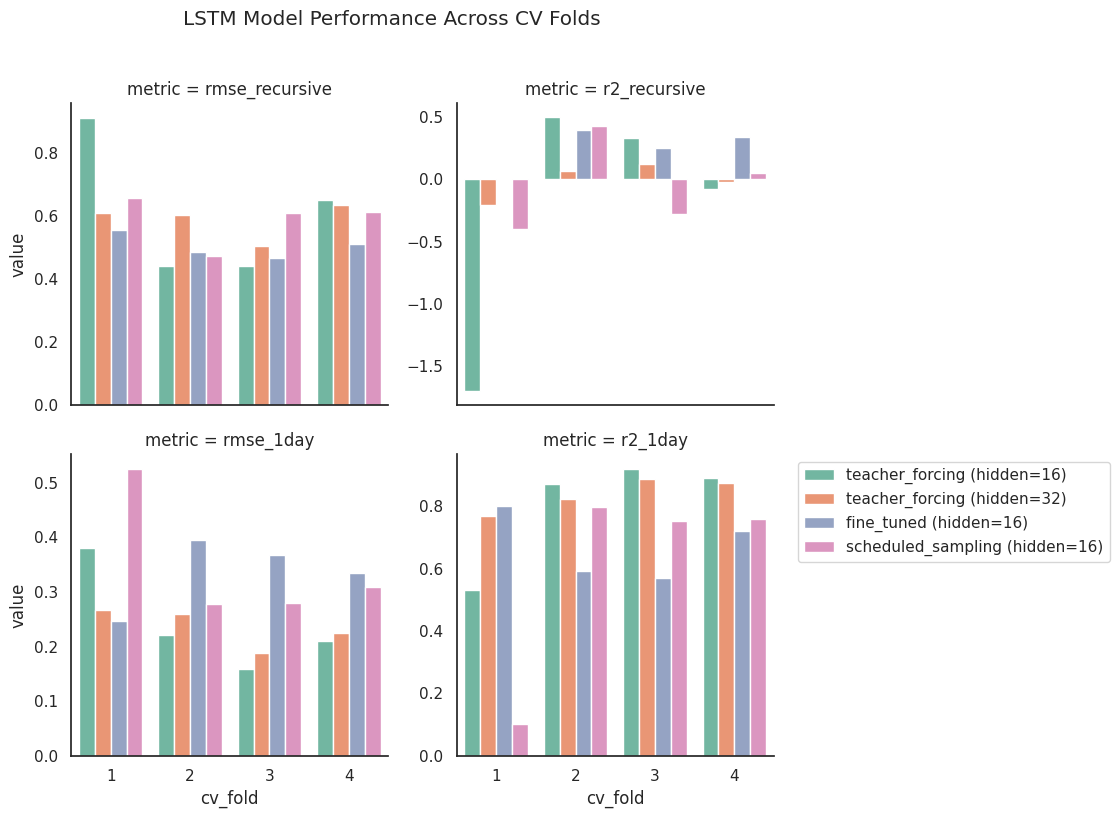

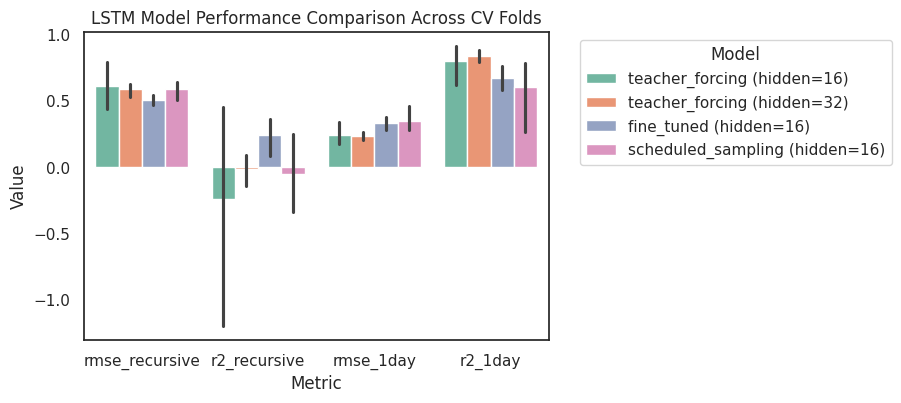

In [83]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:34: UserWarning: color is redundantly defined by the 'color' k

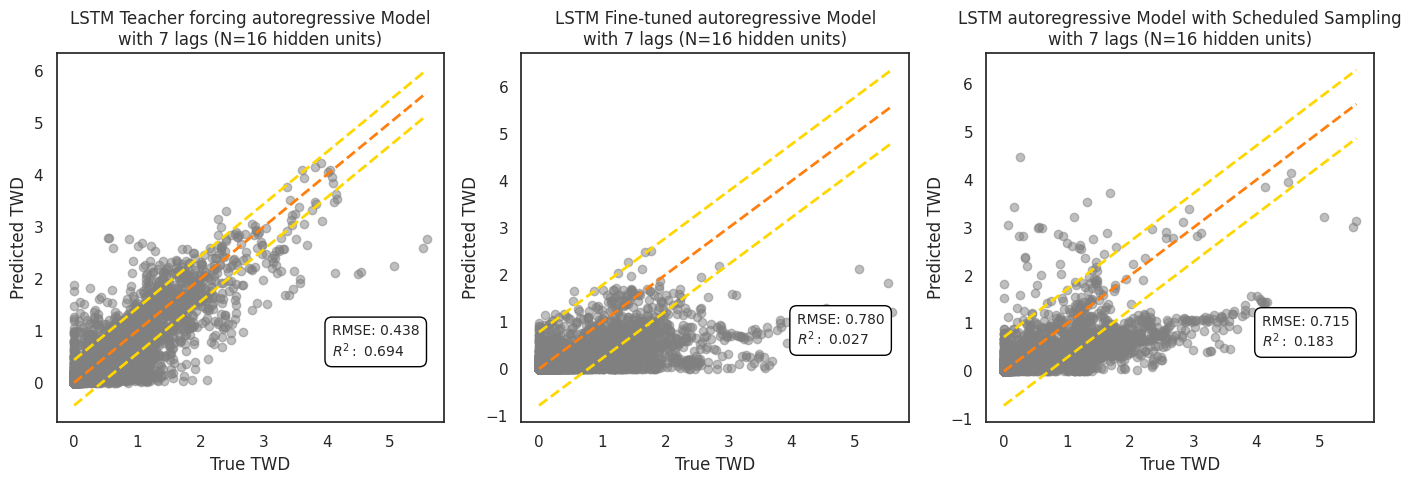

In [88]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
y_val_at = clip_and_inverse_log2_transform(ensure_numpy(y_val_at).reshape(-1))
y_pred_val_at = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at).reshape(-1))
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"LSTM Teacher forcing autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)), y = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)), color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).min(), clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"LSTM Fine-tuned autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax2.text(clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()-1.5,clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)), y = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)), color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).min(), clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"LSTM autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=16 hidden units)")
ax3.text(clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()-1.5,clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



- timeseries prediction across timestep 

why the performance is so bad ..
- try the same on ridge regression?

to improve the model performance
- we can try to improve the LSTM architecture 
    -  added softplus - why it lowered the performance? 
    - play with the architecture and hyperparameter
- add also compute the correlation matrix of lagged features with twd
- should I create cross-validation function to choose the tune the model?
- how can i integrate autoregressive training?
- incorporate log value into traning 
- stack layers? 
- how to extrapolate if i use location and other static parameters in the future?
- perturbation to analyze feature importance